This notebook contains three sections: 1) Fit a spectral peak from Lynx DSA data (digital spectrum analyzer) , 2) Perform energy calibration, 3) Read data from CAEN N957 MCA (analog multichannel analyzer)

# 1 - Fit a spectral peak from Lynx DSA

### First we load libraries

In [1]:
########################################################
# Created on Feb 9 2021                                #
# Modified   Feb 8 2022
# @author: Manel Errando (errando@physics.wustl.edu)   #
# based on code by Zach Hughes                         #
########################################################


# Import modules.
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ast import literal_eval as le
from sys import exit as ex

# Use the seaborn style sheet. Uncomment if you don't like, or add your own customization.
#plt.style.use('seaborn')

# This will make the plots look nice
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['xtick.major.size'] = 8.0
plt.rcParams['xtick.minor.size'] = 4.0

plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['ytick.major.size'] = 8.0
plt.rcParams['ytick.minor.size'] = 4.0

### The following block loads data from the Lynx MCA
The data is stored in two arrays: *ch* and *counts* containing respectively the channel numbers and the number of counts per channel.

In [3]:
# This code block reads data saved from the Lynx DSA
data_file = './Ba-NoAu.csv'

# Read spectral file, it expects 7 lines of header and one final footer line, which are skipped
ch,en,counts = np.genfromtxt(data_file,skip_header=7,skip_footer=1,delimiter=',',unpack='true')

### This block plots the contents of the *counts* array
This shows the spectrum we obtained

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


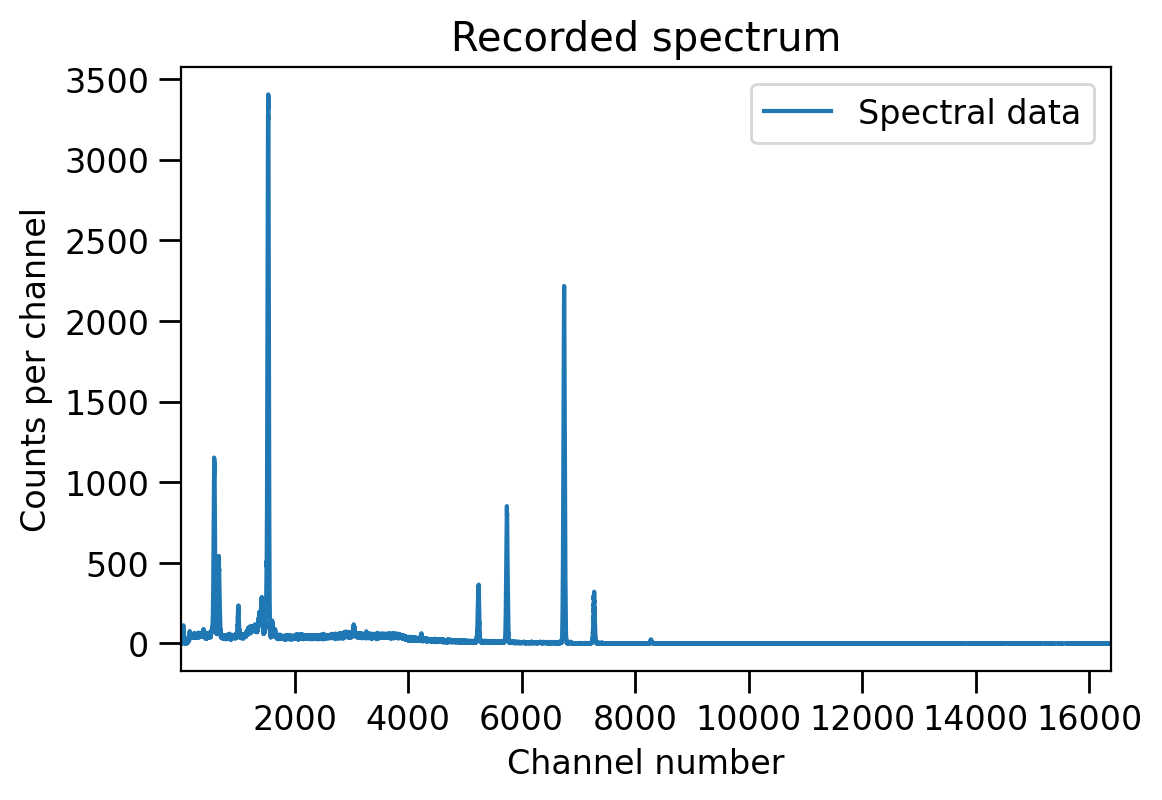

In [4]:
# Set up plot window.
f, ax = plt.subplots()
ax.set_title('Recorded spectrum')
ax.set_ylabel('Counts per channel')

ax.plot(counts, label='Spectral data') # Plots the contents of the counts array
xStart = ch[0]
xEnd = ch[len(ch)-1]
ax.set_xlabel('Channel number')

ax.set_xlim([xStart, xEnd])

plt.legend()
plt.show(block=False) # Don't block terminal by default.

### In the following we define a gaussian function and fit it to one of the spectral peaks

In [5]:
# We define a Gaussian function
# Using definition: https://en.wikipedia.org/wiki/Gaussian_function
def gaussianFunction(x, a, b, c):
    return a * np.exp(-(x-b)**2/(2*c**2))

Now we fit a gaussian to one of the peaks. First look by eye and set the range of channels you want to use for the fit. We will plot the peak to be able to estimate the fit parameters:

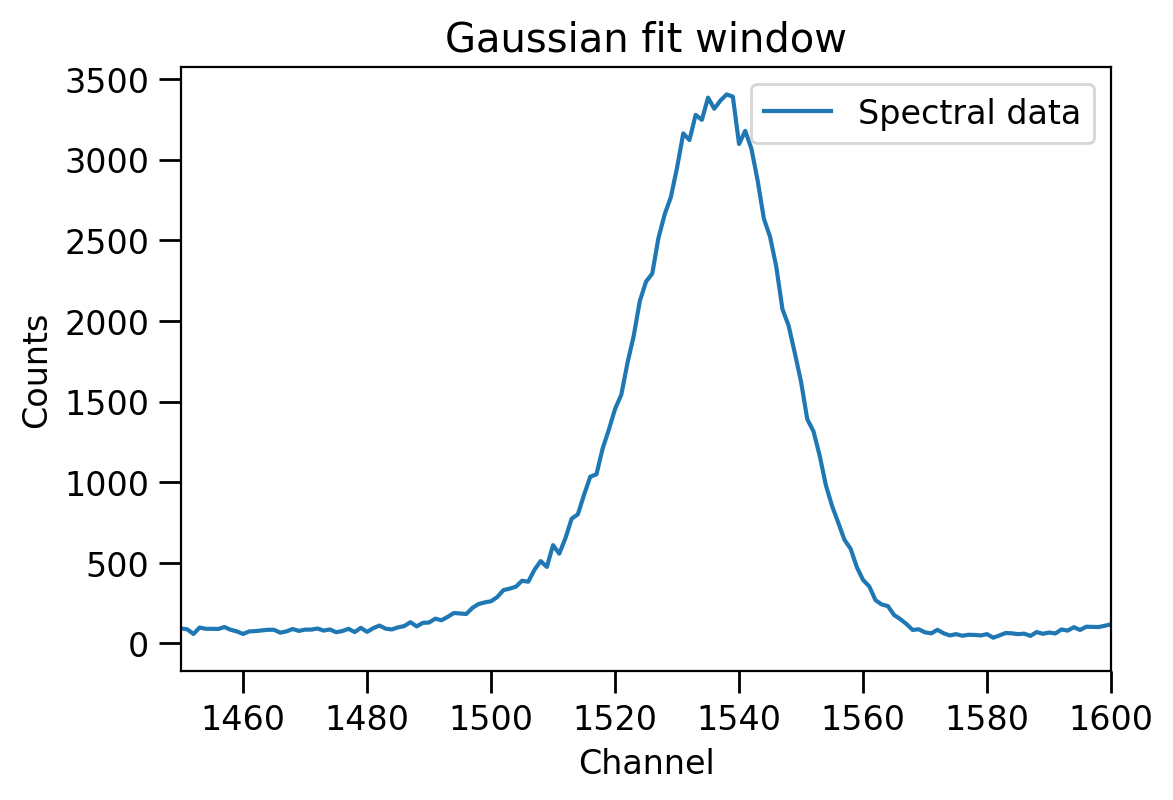

In [8]:
# Set the range of channel numbers where you want to zoom in to see your peak

ZoomLeft  = 1450 # lower bound for the gaussian fit
ZoomRight = 1600 # upper bound for the gaussian fit

# Now we plot that region of the spectrum

popt, pcov = None, None
n = 1000 # How many points to plot in the model fit.

# Set up plot window.
f, ax = plt.subplots()
ax.plot(counts, label='Spectral data')
ax.set_title('Gaussian fit window')
ax.set_xlabel('Channel')
ax.set_ylabel('Counts')

# User looks by eye for where to fit the peak.
#lowerBound = enterNumeric('Enter the lower bound for the gaussian fit: ')
#upperBound = enterNumeric('Enter the upper bound for the gaussian fit: ')
ax.set_xlim(ZoomLeft, ZoomRight)

plt.legend()
plt.show(block=False)

Now we need to select the range of channels where the function looks gaussian and make accurate guesses for the amplitude of the gaussian, the position of the gaussian peak, the standard deviation, and the Y axis offset (basically the baseline that the gaussian is sitting on top of)

In [9]:
# We define a Gaussian function
# Using definition: https://en.wikipedia.org/wiki/Gaussian_function
def three_gauss(x, C, a1, b1, c1, a2, b2, c2):
    return C+gaussianFunction(x,a1,b1,c1)+gaussianFunction(x,a2,b2,c2)

Fitting complete. Optimized values: 
Y axis Offset: 		 71.5  +/- 4.549
Peak amplitude: 	 455.5  +/- 238.329
Peak location: 		 1520.4  +/- 10.855
Standard deviation: 	 15.2  +/- 3.899
Peak amplitude: 	 3062.9  +/- 399.862
Peak location: 		 1536.9  +/- 0.336
Standard deviation: 	 10.9  +/- 0.302
Covariance Matrix: 
[[ 2.06955352e+01 -4.53183998e+02 -2.12454150e+01 -8.72650758e+00
   7.85692150e+02 -5.54137065e-01  4.89509666e-01]
 [-4.53183998e+02  5.68009287e+04  2.57558126e+03  9.05072377e+02
  -9.49132291e+04  7.86109840e+01 -7.10954137e+01]
 [-2.12454150e+01  2.57558126e+03  1.17824555e+02  4.18338579e+01
  -4.33868827e+03  3.51404199e+00 -3.20433616e+00]
 [-8.72650758e+00  9.05072377e+02  4.18338579e+01  1.52000474e+01
  -1.54135502e+03  1.20707168e+00 -1.11636665e+00]
 [ 7.85692150e+02 -9.49132291e+04 -4.33868827e+03 -1.54135502e+03
   1.59889700e+05 -1.29566202e+02  1.17975131e+02]
 [-5.54137065e-01  7.86109840e+01  3.51404199e+00  1.20707168e+00
  -1.29566202e+02  1.12863291e-01 

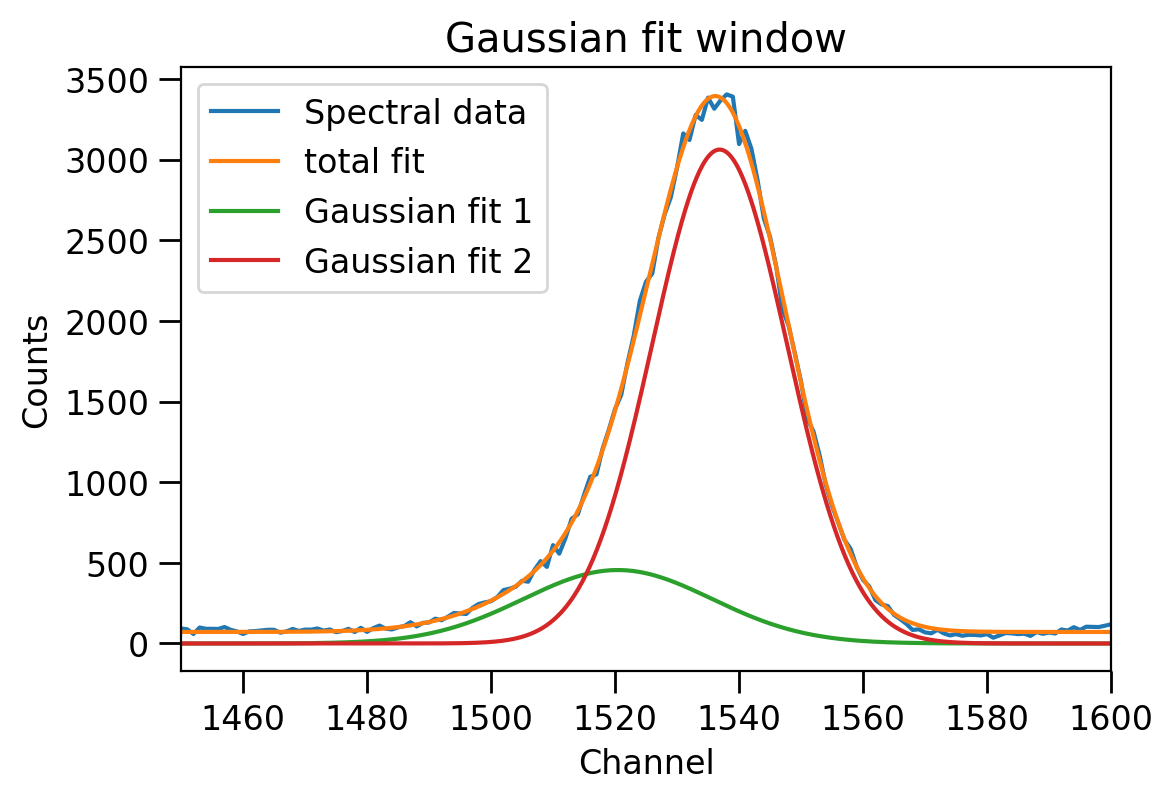

In [10]:
# Boundaries of the fit in channel number
lowerBound = 1450 # lower bound for the gaussian fit
upperBound = 1600 # upper bound for the gaussian fit


# Backgorund fit, estimates
guessConst = 100    # estimate for Y offset or baseline, in counts
# guessA1 = 10   # estimate for the amplitude at the peak, in counts
# guessB1 = 180   # estimate for the position pf the peak, in channel number
# guessC1 = 50    # estimate for the standard deviation, in channels (~ half of the FWHM)

# Low energy peak fit, estimates
guessA1 = 3000   # estimate for the amplitude at the peak, in counts
guessB1 = 1530   # estimate for the position pf the peak, in channel number
guessC1 = 40    # estimate for the standard deviation, in channels (~ half of the FWHM)

# High energy peak fit, estimates
guessA2 = 3000   # estimate for the amplitude at the peak, in counts
guessB2 = 1540   # estimate for the position pf the peak, in channel number
guessC2 = 40    # estimate for the standard deviation, in channels (~ half of the FWHM)

# This lines set lower (lb) and upper (ub) boundaries to the parameters. It is importnat to set boundaries
# to the peak positions so that the fit does not wander off. 
lb = [0.    , 0.   ,1500 ,0.    ,0.      ,1500,  0.   ]
ub = [np.inf,np.inf,1700 ,np.inf, np.inf ,1700, np.inf]

# Set up plot window.
f, ax = plt.subplots()
ax.plot(counts, label='Spectral data')
ax.set_title('Gaussian fit window')
ax.set_xlabel('Channel')
ax.set_ylabel('Counts')
ax.set_xlim(ZoomLeft, ZoomRight)

# Restrict the fit region to user bounds.
p0 = [guessConst,guessA1, guessB1, guessC1, guessA2, guessB2, guessC2]
xData = np.arange(lowerBound, upperBound)
yData = counts[lowerBound:upperBound]


# Do the fit.
try:
    popt, pcov = curve_fit(three_gauss, xData, yData, p0=p0,bounds=(lb,ub))
    perr = np.sqrt(np.diag(pcov))
except Exception as e:
    print(e)
    print('Something went wrong with the fit. Did it not converge?')

# If it was successful, print it out and update the plot.
if popt is not None:
    print('Fitting complete. Optimized values: ')
    print('Y axis Offset: \t\t',    "{:.1f}".format(popt[0]), ' +/-', "{:.3f}".format(perr[0]))
    print('Peak amplitude: \t',     "{:.1f}".format(popt[1]), ' +/-', "{:.3f}".format(perr[1]))
    print('Peak location: \t\t',    "{:.1f}".format(popt[2]), ' +/-', "{:.3f}".format(perr[2]))
    print('Standard deviation: \t', "{:.1f}".format(popt[3]), ' +/-', "{:.3f}".format(perr[3]))
    print('Peak amplitude: \t',     "{:.1f}".format(popt[4]), ' +/-', "{:.3f}".format(perr[4]))
    print('Peak location: \t\t',    "{:.1f}".format(popt[5]), ' +/-', "{:.3f}".format(perr[5]))
    print('Standard deviation: \t', "{:.1f}".format(popt[6]), ' +/-', "{:.3f}".format(perr[6]))
    print('Covariance Matrix: ')
    print(pcov)
    xModel = np.linspace(lowerBound, upperBound, n)
    yModel = three_gauss(xModel, *popt)
    yModel1 = gaussianFunction(xModel, popt[1], popt[2], popt[3])
    yModel2 = gaussianFunction(xModel, popt[4], popt[5], popt[6])
    ax.plot(xModel, yModel, label='total fit')
    ax.plot(xModel, yModel1, label='Gaussian fit 1')
    ax.plot(xModel, yModel2, label='Gaussian fit 2')
    plt.legend()
    plt.draw()

In [15]:
print(popt)

[  68.38651155  271.25468289 1510.27183283   11.96537813 3286.07933643
 1536.17119623   11.11394674]
